<a href="https://colab.research.google.com/github/EnriqueGRivas/Analisis_Bluex/blob/main/PP1/4_Segmentaci%C3%B3n_de_Clientes_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=black size = 6 face="Verdana"><center><strong>SUPPLY CHAIN ANALYTICS - Gestión Moderna de la Cadena de Suministros</center></font>


  <font color=black><center>Fecha: 24-08-2024</center>


  <font color=#48c9b0><center>Elaborado por: Mg. Ec. Enrique F. Gutierrez Rivasplata</center>

En este cuaderno abordamos el problema de la **Segmentación de Clientes**, que desempeña una regla crucial en el Marketing moderno centrado en el cliente. Este conjunto de datos de Venta Retail de linea, contiene todas las transacciones realizadas para una venta minorista en línea con 2 tiendas registradas y con sede en el C.C Salaverry y el C.C Jockey Plaza, entre el 01/01/2015 y el 01/03/2018. La empresa vende principalmente artículos de instrumentos musicales. Muchos clientes de la empresa son minoristas y mayoristas. El conjunto de datos está disponible en <a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail+II">conjuntos de datos</a>.<br/>

### **Importando Paquetes:**

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import datetime as dt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

# Preprocesado y modelado
# ==============================================================================
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


### **Lectura y Comprensión de los Datos:**

In [ ]:
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leer el archivo Excel con los datos simulados
# ==============================================================================
data = pd.read_excel('/content/drive/MyDrive/Análisis - Python/DATOS/Data1.xlsx')


# Copiamos el dataframe
# ==============================================================================
df = data.copy()

# Mostrar las primeras filas del dataframe
# ==============================================================================
df.head()

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingresos_por_Distribucion_SDD,Ingresos_por_Falsos_Fletes,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica
0,2015-01-03,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,66603.25,0.0,349.650000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385
1,2015-01-03,2204384,3112,1097514,Shipping,Standard Class,EMP-20449216343,2015-01-05,2015-01-05,27,...,3379.95,0.0,413.696970,194.472935,49.0,344.747475,663.329501,3379.95,70.425,4113.704501
2,2015-01-03,2204387,3115,204754,Shipping,Standard Class,CON-10004331147,2015-01-05,2015-01-05,22,...,66150.00,0.0,8.910000,4.188462,11.8,7.425000,14.286462,66150.00,4488.750,70653.036462
3,2015-01-03,2204382,3110,1001830,Shipping,Standard Class,CON-10181604579,2015-01-05,2015-01-06,90,...,0.00,32387.4,137.576863,64.672884,19.2,114.647385,220.593328,21752.75,32387.400,54360.743328
4,2015-01-05,2204395,3123,1001830,Shipping,Standard Class,EMP-20447989051,2015-01-06,2015-01-06,81,...,30453.85,32387.4,137.576863,64.672884,19.2,114.647385,220.593328,30453.85,32387.400,63061.843328


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print(f'El dataframe tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataframe tiene 26162 filas y 81 columnas.


<a id='part1'></a>
## <font color=#ba4a00><strong>Exploración y Preprocesamiento de Datos:

* Resumen del número y porcentaje de valores faltantes en cada variable.

In [ ]:
# Identifique la cantidad de NAs en cada característica y seleccione solo aquellas que tengan NAs
total_NA = df.isnull().sum()[df.isnull().sum() != 0]

# Calcular el porcentaje de NAs en cada característica.
percent_NA = df.isnull().sum()[df.isnull().sum() != 0]/data.shape[0]

# Resumir nuestros hallazgos en un marco de datos
missing = pd.concat([total_NA, percent_NA], axis=1, keys=['Total NAs', 'Percentage']).sort_values('Total NAs', ascending=False)
missing

,Total NAs,Percentage
Proceso_Devol,21535,0.82314
Cod_Cliente_Devol,21535,0.82314


**Nota:** Si las transacciones a las que les faltan ID de cliente no serán útiles para crear segmentos de clientes. Así que los dejaríamos.

In [ ]:
# Numero de Registro duplicados
# ==============================================================================
print('Número de registros duplicados: ', df.duplicated(keep='first').sum())

Número de registros duplicados:  2


In [ ]:
# Eliminar registros duplicados
# ==============================================================================
indx = df[df.duplicated(keep='first')].index
df.drop(index = indx, inplace= True)

* Afirmar que "Cod_Prod" y "Cod_Cliente" son de tipo de datos de cadena (str), no enteros (int) ni flotantes (float).

In [ ]:
# Verificando las variables
# ==============================================================================
#df.info()

In [ ]:
# Transformando las variables "Cod_Prod" y "Cod_Cliente"
# ==============================================================================
df['Cod_Prod'] = df['Cod_Prod'].astype(str)  # Asignar a una sola columna

# Manejar valores no numéricos en 'Cod_Cliente'
# Reemplazar 'CON-' y cualquier otro prefijo no numérico antes de la conversión
df['Cod_Cliente'] = df['Cod_Cliente'].str.replace(r'\D+', '', regex=True).astype(int).astype(str)

* Número de tipos de datos diferentes en el conjunto de datos.

In [ ]:
# Tipos de datos
# ==============================================================================
df.dtypes.value_counts()

,count
object,32
float64,30
int64,15
datetime64[ns],4


* Generar estadísticas resumidas para todas las variables numericas.

In [ ]:
# Estadísticas resumidas de variables categóricas.
# ==============================================================================
#df.select_dtypes(include='float64').describe().T # Podemos cambiar a "int64 u "object"
# Previamente hay que convertir las variables numericas que no son necesarias para el analisis

In [ ]:
# Estadísticas resumidas de variables numéricas.
# ==============================================================================
#df.select_dtypes(include= ['int64', 'float64']).describe().transpose() # Se pueden poner dos tipos de variables

* Generar estadísticas descriptivas para la variable "F_Orden".

In [ ]:
# Estadísticas resumidas de la variable "F_Orden"
# ==============================================================================
df[['F_Orden']].describe().T

,count,mean,min,25%,50%,75%,max
F_Orden,26160,2016-03-23 07:09:47.889908224,2015-01-03 00:00:00,2015-06-11 00:00:00,2015-12-03 00:00:00,2016-12-18 00:00:00,2017-12-31 00:00:00


* Clientes del distrito de Surco y fuera del Distrito de Surco.

In [ ]:
df.Distrito[df.Distrito == 'Surco'].value_counts()

,count
Distrito,
Surco,8951


In [ ]:
# Dataset del Distrito de Surco vs los que no son del Distrito
# ==============================================================================
x = df.Distrito.apply(lambda x: x if x == 'Surco' else 'No Surco').value_counts().rename('#Clientes')
y = (x/df.shape[0]).rename('%Clientes')
pd.concat([x, y], axis= 1)

,#Clientes,%Clientes
Distrito,,
No Surco,17209,0.657836
Surco,8951,0.342164


* Las transacciones con una letra 'C' al comienzo de sus números de factura son transacciones canceladas, por lo que las descartamos.

In [ ]:
# Eliminar transacciones canceladas
# ==============================================================================
#canc = df.Factura[df.Factura.str.contains('C') == True].index
#df.drop(index = canc, inplace= True)
# En nuestro caso no existe en la variable "Factura" ese texto de cadena

* Algunas transacciones tienen un precio de venta de cero, estos podrían ser obsequios para algunos clientes y no una verdadera transacción de venta. Así que los dejaremos.

In [ ]:
# Eliminar transacciones con precio cero
# ==============================================================================
cero = df.loc[df.P_Venta == 0].index
df.drop(index = cero, inplace= True)

<a id='part2'></a>
## <font color=#ba4a00><strong>Ingeniería de características:

Usaremos el modelo RFM además de otras dos medidas, **Primera Compra** y **Nro. de Artículos Únicos**, para crear segmentos de clientes. **RFM** significa *Reciente, Frecuencia y Valor_monetario*:
* **Actualidad:** es una medida de cuánto tiempo ha pasado desde la última vez que un cliente realizó un pedido a la empresa.
* **Primera_compra:** Tiempo en el mes desde la primera compra.
* **Frecuencia:** es una medida de la frecuencia con la que un cliente realiza un pedido a la empresa.
* **Valor monetario:** Monto que gasta un cliente en una transacción promedio.
* **Unicos_items:** es la medida del número promedio de artículos únicos por transacción. Esta medida se puede utilizar para distinguir entre clientes organizacionales y clientes individuales.

* Calcular el monto de ventas para cada transacción que es el producto del precio de venta y la cantidad.

In [ ]:
# Monto por transacción que es el producto del precio de venta y la cantidad
# ==============================================================================
df['Venta'] = df['P_Venta'] * df['Cant_Enviada']

* Separar el tiempo de transacción (en horas) de la fecha de la transacción.

In [ ]:
# Crear nueva variable para el tiempo de factura en horas
# ==============================================================================
df['Transaccion_hora'] = df.F_Orden.apply(lambda x : x.time().hour)

In [ ]:
# Crear nueva variable para la fecha de la factura
# ==============================================================================
df['Transaccion_fecha'] = df.F_Orden.apply(lambda x : x.date())
df['Transaccion_fecha'] = df.Transaccion_fecha.apply(lambda x: x.replace(day = 1))

* Para cada transacción, calcularemos el número de meses desde la fecha de la primera transacción hasta el final de la última del año (diciembre de 2018).

In [ ]:
# Calcular el Nro. de meses desde la primera fecha de la transacción.
# ==============================================================================
ref = datetime.strptime('2015-01', '%Y-%m')
df['Meses_desde_compra'] = df.Transaccion_fecha.apply(lambda x: \
                                        relativedelta(ref,x).years*12 + relativedelta(ref,x).months)
Recencia = df.groupby('Cod_Cliente').agg({'Meses_desde_compra' : 'min'}).copy().rename(columns= {'Meses_desde_compra':'Recencia'})

* Para cada cliente, calcular el número de meses desde su primera compra.

In [ ]:
# Calcular el número de meses desde la primera compra de cada cliente
# ==============================================================================
df['Primera_compra'] = df['Meses_desde_compra'].copy()
Primera_compra = df.groupby('Cod_Cliente').agg({'Primera_compra' : 'max'}).copy().rename(columns= {'Meses_desde_compra':'Primera_compra'})

* Para cada cliente, calcularemos el número promedio de transacciones por mes (Frecuencia).

In [ ]:
# Número promedio de transacciones por cliente
# ==============================================================================
Frecuencia = df.groupby(['Cod_Cliente',
                    'Transaccion_fecha']).agg({'Factura' : 'nunique'}).groupby(['Cod_Cliente']).agg({'Factura' : 'mean'}).copy().rename(columns= {'Factura':'Frecuencia'})

* Para cada cliente, calcularemos el monto promedio de compra por transacción (Valor monetario).

In [ ]:
# Monto Promedio por Transaccion y Cliente
# ==============================================================================
Valor_Monetario = df.groupby(['Cod_Cliente',
                    'Factura']).agg({'Venta' : 'sum'}).groupby(['Cod_Cliente']).agg({'Venta' : 'mean'}).copy().rename(columns= {'Factura':'Frecuencia','Venta': 'Valor_Monetario'})

* Para cada cliente, calcularemos el número promedio de artículos únicos en cada transacción.

In [ ]:
# Calcular el número promedio de artículos únicos en cada transacción para cada cliente
# ==============================================================================
Unicos_items = df.groupby(['Cod_Cliente', 'Factura']).agg({'Cod_Prod': 'nunique'}).groupby(['Cod_Cliente']\
            ).agg({'Cod_Prod':'mean'}).rename(columns={'Cod_Prod': 'Unicos_items'})

* Reuniremos todas las variables calculadas en un nuevo dataframe que se utilizaremos más adelante para el entrenamiento del modelo.

In [ ]:
# Crear datos transformados para clustering
# ==============================================================================
data_variables = pd.concat([Recencia, Primera_compra, Frecuencia, Valor_Monetario, Unicos_items], axis=1)
data_variables.describe()

,Recencia,Primera_compra,Frecuencia,Valor_Monetario,Unicos_items
count,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,-27.649491,-19.807070,1.518531,32682.265703,3.636183
std,7.075388,8.409694,2.887046,54509.720090,1.901032
min,-35.000000,-35.000000,1.000000,622.782997,1.000000
25%,-34.000000,-26.000000,1.000000,8389.682990,2.333333
50%,-30.000000,-20.000000,1.000000,16322.306733,3.000000
75%,-23.000000,-16.000000,1.000000,34845.790486,5.000000
max,-6.000000,0.000000,65.153846,618169.289353,13.000000


In [ ]:
data_variables.head()

,Recencia,Primera_compra,Frecuencia,Valor_Monetario,Unicos_items
Cod_Cliente,,,,,
10002050,-28,-22,1.000000,28024.819625,3.500000
10002327,-29,-18,1.000000,8881.563622,3.000000
10004331147,-15,0,2.666667,14107.020885,1.208333
10005140272,-14,0,3.142857,2704.765849,1.000000
10008194,-32,-32,1.000000,28548.000000,5.000000


* Trazaremos la distribución de todas las variables para detectar posibles valores atípicos y decidir si es necesaria la normalización.

<Axes: xlabel='Unicos_items'>

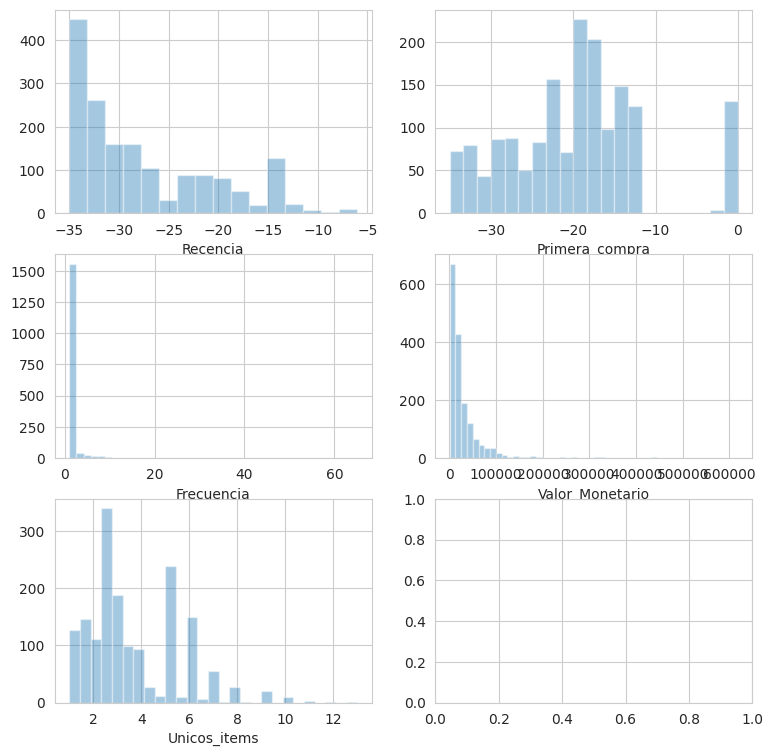

In [ ]:
# Trazar la distribución de todas las variables que se utilizarán para el entrenamiento del modelo.
# ==============================================================================
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_variables.Recencia, ax= ax[0][0], kde= False)
sns.distplot(data_variables.Primera_compra, ax= ax[0][1], kde= False)
sns.distplot(data_variables.Frecuencia, ax= ax[1][0], kde= False)
sns.distplot(data_variables.Valor_Monetario, ax= ax[1][1], kde= False)
sns.distplot(data_variables.Unicos_items, ax= ax[2][0], kde= False)

Los gráficos muestran algunos valores atípicos potenciales tanto en la Frecuencia como en el Valor Monetario, por lo que eliminaremos a esos clientes de nuestro conjunto de datos. De modo que los clientes tengan más de la $\mu=3$ y $\sigma=1$ estándar (es decir, puntuación Z > 3). será eliminado.

In [ ]:
# Definamos el valor del umbral de frecuencia y eliminaremos a los clientes que superen el umbral.
# ==============================================================================
frec_stats = data_variables['Frecuencia'].describe()
umbral_frec = frec_stats['mean'] + 3 * frec_stats['std']
indx = data_variables.loc[data_variables.Frecuencia > umbral_frec].index
data_variables.drop(index = indx, inplace= True)

In [ ]:
# Definimos el valor umbral del valor monetario y elimine a los clientes que superen el umbral
# ==============================================================================
m_stats = data_variables['Valor_Monetario'].describe()
m_umbral = m_stats['mean'] + 3 * m_stats['std']
indx = data_variables.loc[data_variables.Valor_Monetario > m_umbral].index
data_variables.drop(index = indx, inplace= True)

<Axes: xlabel='Unicos_items'>

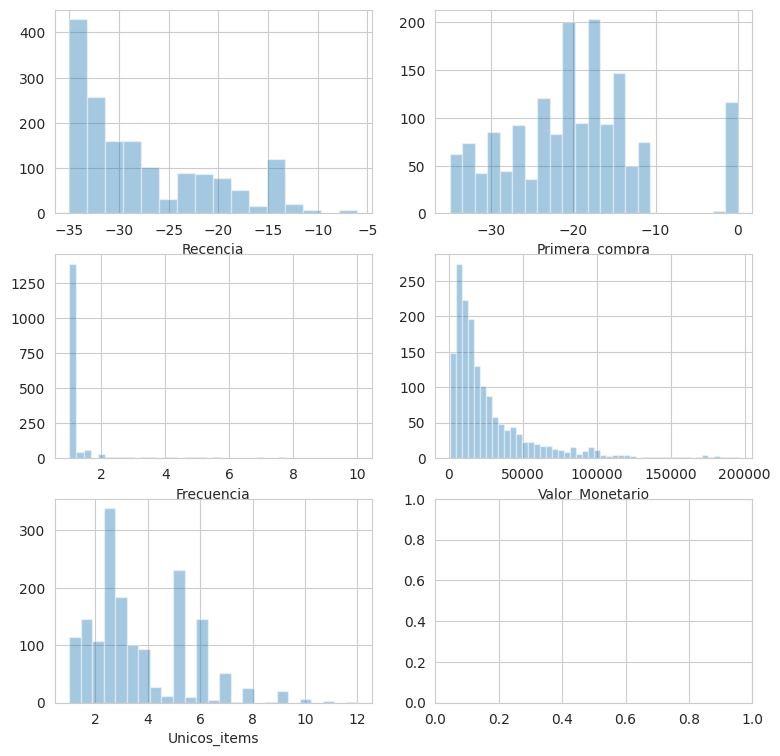

In [ ]:
# Trazamos nuevamente la distribución de todas las variables que se utilizarán para el entrenamiento del modelo.
# ==============================================================================
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_variables.Recencia, ax= ax[0][0], kde= False)
sns.distplot(data_variables.Primera_compra, ax= ax[0][1], kde= False)
sns.distplot(data_variables.Frecuencia, ax= ax[1][0], kde= False)
sns.distplot(data_variables.Valor_Monetario, ax= ax[1][1], kde= False)
sns.distplot(data_variables.Unicos_items, ax= ax[2][0], kde= False)

* Los gráficos muestran que las variables tienen escalas muy diferentes y algunas de ellas están muy sesgadas. Entonces normalizaremos todas las variables.

In [ ]:
# Normalizar las cuatro variables.
# ==============================================================================
scaler = pp.StandardScaler()
data_variables_scaled = pd.DataFrame(scaler.fit_transform(data_variables),
                                       columns= data_variables.columns)

<Axes: xlabel='Unicos_items'>

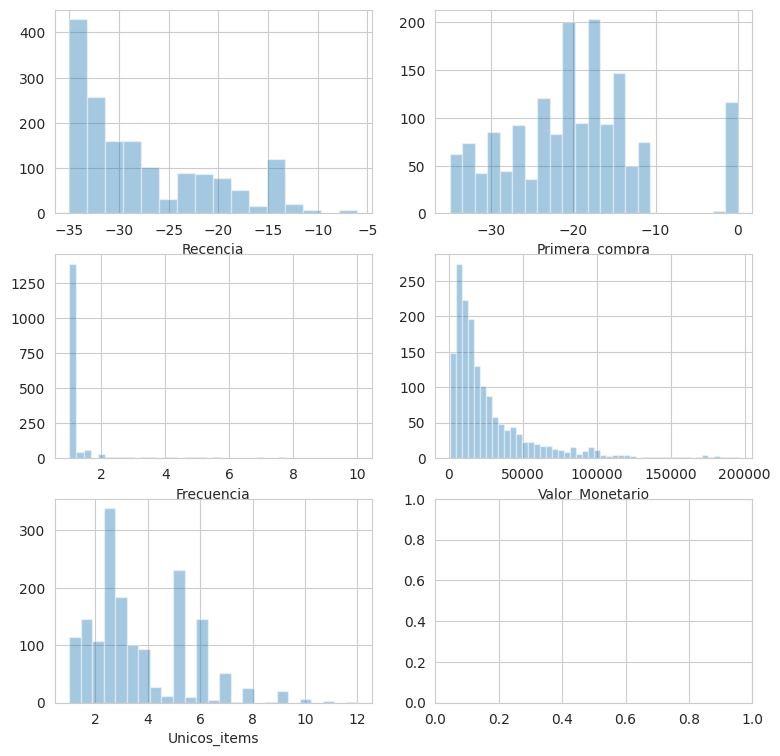

In [ ]:
# Trazamos nuevamente la distribución de todas las variables que se utilizarán para el entrenamiento del modelo.
# ==============================================================================
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_variables.Recencia, ax= ax[0][0], kde= False)
sns.distplot(data_variables.Primera_compra, ax= ax[0][1], kde= False)
sns.distplot(data_variables.Frecuencia, ax= ax[1][0], kde= False)
sns.distplot(data_variables.Valor_Monetario, ax= ax[1][1], kde= False)
sns.distplot(data_variables.Unicos_items, ax= ax[2][0], kde= False)

<a id='part3'></a>
## <font color=#ba4a00><strong>Entrenamiento del Modelo:

#### **Probando los Modelos Candidatos**

Comenzaremos probando varios algoritmos de agrupación y seleccionaremos los más prometedores. Dado que se desconocen las etiquetas de verdad del terreno, la evaluación se realizará utilizando el modelo mismo. Usaremos tres medidas para evaluar los modelos de agrupamiento:
 * **Puntuación de Davies Bouldin:** significa la similitud promedio entre conglomerados, donde la similitud es una medida que compara la distancia entre conglomerados con el tamaño de los conglomerados mismos. Cero es la puntuación más baja posible. Los valores más cercanos a cero indican una mejor partición.
 * **Puntuación de Calinski Harabasz (también conocida como Criterio de relación de varianza):** es la relación entre la suma de la dispersión entre conglomerados y la dispersión entre conglomerados para todos los conglomerados (donde la dispersión se define como la suma de distancias al cuadrado). La puntuación es mayor cuando los racimos son densos y bien separados.
 * **Puntuación de silueta:** la puntuación está limitada entre -1 para agrupaciones incorrectas y +1 para agrupaciones muy densas. Las puntuaciones cercanas a cero indican grupos superpuestos

In [ ]:
# Una función para automatizar el ajuste y la predicción del modelo.
# ==============================================================================
def model_train(estimador, df, a,b):
    db = []
    ca = []
    sc = []
    bic = []
    aic = []
    n_clusters = {'n_clusters':[]}
    if (estimador == AffinityPropagation)|(estimador == DBSCAN)|(estimador == OPTICS)|(estimador==Birch):
        est = estimador()
        est.fit(df)
        labels = est.labels_
        if np.unique(est.labels_).shape[0] > 1:
            db.append(davies_bouldin_score(df, labels))
            ca.append(calinski_harabasz_score(df, labels))
            sc.append(silhouette_score(df, labels))
            n_clusters['n_clusters'].append('N/A')
        else:
            n_clusters['n_clusters'].append(np.unique(est.labels_).shape[0])

    else:
        for k in range(a, b):
            if estimador == GaussianMixture:
                est = estimador(n_components= k)
                labels = est.fit_predict(df)
            else:
                est = estimador(n_clusters= k)
                est.fit(df)
                labels = est.labels_

            db.append(davies_bouldin_score(df, labels))
            ca.append(calinski_harabasz_score(df, labels))
            sc.append(silhouette_score(df, labels))

        n_clusters['n_clusters'].append(np.argmin(db) + a)
        n_clusters['n_clusters'].append(np.argmax(ca) + a)
        n_clusters['n_clusters'].append(np.argmax(sc) + a)
    return db, ca, sc, labels, n_clusters['n_clusters']

In [ ]:
# Trazar diferentes medidas contra el número de grupos para algoritmos que no requieren de conglomerados a priori.
# ==============================================================================
def plot_scores(a,b, db, ca, sc):
    fig, ax = plt.subplots(nrows= 1, ncols=3, figsize=(15,4))
    ax[0].plot(range(a, b), db, "bo-", label= 'Davies_Bouldin_Score')
    ax[1].plot(range(a, b), ca, "rx-", label = 'Calinski_Harabasz_Score')
    ax[2].plot(range(a, b), sc, "g.-", label = 'Silhouette_Score')
    ax[0].set_xlabel("$k$", fontsize=14)
    ax[1].set_xlabel("$k$", fontsize=14)
    ax[2].set_xlabel("$k$", fontsize=14)
    ax[0].set_ylabel('Davies Bouldin Score', fontsize=14)
    ax[1].set_ylabel('Calinski Harabasz Score', fontsize=14)
    ax[2].set_ylabel('Silhouette Score', fontsize=14)
#     plt.legend(loc=(1,0),fontsize=14)
    plt.show()

Intentaremos entrenar los siguientes algoritmos:
* K-Means.
* Propagación por afinidad.
* Agrupación jerárquica aglomerativa.
* Abedul.
* DBSCAN.
* Modelo de Mezcla Gaussiana.
* ÓPTICA.
* Agrupación espectral.

Para aquellos algoritmos que necesitan el número de clústeres a priori, probaremos el rango de valores entre 3 y 7 y seleccionaremos el mejor modelo en función de las métricas de evaluación.

In [ ]:
# Modelos de Entrenamiento
# ==============================================================================
clusterers = [KMeans, AffinityPropagation, AgglomerativeClustering, Birch,
             DBSCAN, GaussianMixture, OPTICS, SpectralClustering]

Scores ={'Davies_Bouldin_Score': [],
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': [],
        'n_clusters': []}

clusterer_names = ['K-Means', 'Affinity Propagation', 'Agglomerative Clustering', 'Birch',
             'DBSCAN', 'Gaussian Mixture Model', 'OPTICS', 'Spectral Clustering']

for i in clusterers:
    db, ca, sc, labels, n_clusters= model_train(i, data_variables_scaled, 3, 8)

    Scores['Davies_Bouldin_Score'].append(np.min(db))
    Scores['Calinski_Harabasz_Score'].append(np.max(ca))
    Scores['Silhouette_Score'].append(np.max(sc))
    Scores['n_clusters'].append(n_clusters)

In [ ]:
# Metricas de cada modelo
# ==============================================================================
models_scores = pd.DataFrame(Scores, index= clusterer_names)
models_scores

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
K-Means,0.890565,854.825766,0.370867,"[6, 4, 4]"
Affinity Propagation,1.081705,463.491861,0.233920,[N/A]
Agglomerative Clustering,0.885104,801.664836,0.357064,"[5, 3, 4]"
Birch,0.883623,558.234803,0.429563,[N/A]
DBSCAN,1.512959,78.423293,-0.110955,[N/A]
Gaussian Mixture Model,1.938143,482.636909,0.153595,"[6, 5, 5]"
OPTICS,1.254237,19.640468,-0.371571,[N/A]
Spectral Clustering,0.475248,408.308580,0.541943,"[4, 3, 3]"


#### **Seleccionando algunos modelos prometedores**

* **Mejor modelo según "Davies_Bouldin_Score":**

In [ ]:
# Selección automática del mejor modelo según Davies
# ==============================================================================
models_scores.loc[models_scores.Davies_Bouldin_Score == models_scores.Davies_Bouldin_Score.min()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
Spectral Clustering,0.475248,408.30858,0.541943,"[4, 3, 3]"


* **Mejor modelo según "Calinski_Harabasz_Score":**

In [ ]:
# Selección automática del mejor modelo según Calinski
# ==============================================================================
models_scores.loc[models_scores.Calinski_Harabasz_Score == models_scores.Calinski_Harabasz_Score.max()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
K-Means,0.890565,854.825766,0.370867,"[6, 4, 4]"


* **Mejor modelo según "Silhouette_Score":**

In [ ]:
# Selección automática del mejor modelo según Métrica de la Silueta
# ==============================================================================
models_scores.loc[models_scores.Silhouette_Score == models_scores.Silhouette_Score.max()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
Spectral Clustering,0.475248,408.30858,0.541943,"[4, 3, 3]"


Ahora tenemos 3 modelos prometedores, agrupación espectral con 3 y 4 grupos y Kmeans con 4 y 6 grupos. A continuación, encontraremos el mejor modelo con el mejor número de conglomerados que dé como resultado una interpretación más clara de la separación entre conglomerados.

### **Optimizar Modelos Seleccionados**

In [ ]:
# Modelos Optimizados
# ==============================================================================
def cluster_stats(model, df, data_variables):
    df1 = data_variables.copy()
    df1['Cluster'] = pd.Series(model.labels_, name= 'Cluster', index= data_variables.index)
    df1['Nro_compras'] = df.groupby('Cod_Cliente')['Factura'].count()[df1.index]
    df1['Total_Ventas'] = df.groupby('Cod_Cliente')['Venta'].sum()[df1.index]
    cluster_stats = df1.groupby('Cluster').agg({'Recencia': ['min', 'mean','max'],
                                       'Frecuencia': ['min', 'mean','max'],
                                       'Valor_Monetario': ['min', 'mean','max'],
                                       'Primera_compra': ['min', 'mean','max'],
                                       'Unicos_items': ['min', 'mean','max']}).copy().round(1)
    return cluster_stats, df1

In [ ]:
def clusters_summary(df1, df):
    columns = {'#Clientes':[], '#Compras':[], 'Total_Ventas':[]}
    indx =[]
    for i in np.sort(df.Cluster.unique()):
        columns['#Clientes'].append(df.iloc[df1.loc[df1.Cluster == i].index].shape[0])
        columns['#Compras'].append(df1['No._Purchases'].loc[df1.Cluster == i].sum())
        columns['Total_Ventas'].append(df1['Total_Ventas'].loc[df1.Cluster == i].sum())
        indx.append('Cluster{}'.format(i))

    # Síntesis de un dataframe para el resumen del clúster
    clusters_summary = pd.DataFrame(df = columns, index = indx)

    clusters_summary['%clientes'] = (clusters_summary['#Clientes']/df1.shape[0])*100
    clusters_summary['%transacciones'] = (clusters_summary['#Compras']/df1['Nro_compras'].sum())*100
    clusters_summary['%sales_total'] = (clusters_summary['Total_Ventas']/df1['Total_Ventas'].sum())*100
    columnsOrder = ['#Clientes', '%clientes', '#Compras', '%transacciones', 'Total_Ventas', '%sales_total']
    return clusters_summary.reindex(columns=columnsOrder)

In [ ]:
def plot_3d(cluster_stat):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(cluster_stat['Recencia'], cluster_stat['Frecuencia'], cluster_stat['Valor_Monetario'],
                     c=cluster_stat['Cluster'], s=60, marker=".",
                         cmap= 'prism', edgecolor= 'k', linewidths= 0.6)
    # produce a legend with the unique colors from the scatter
#     legend1 = ax.legend(*scatter.legend_elements(),
#                         loc="center right", title="Customer Segments",
#               bbox_to_anchor=(0.75, 0, 0.5, 1), fontsize= 12)
#     ax.add_artist(legend1)
    ax.set_xlabel('Recencia', fontsize= 12)
    ax.set_ylabel('Frecuencia', fontsize= 12)
    ax.set_zlabel('Valor_Monetario', fontsize= 12)

In [ ]:
def plot_dist(df1, col):
    n= df1['Cluster'].nunique()
    mpl.rcParams['figure.figsize'] = (12,12)
    fig, ax = plt.subplots(ncols=2 , nrows= (n//2))
    k = 0
    h=0
    for j in col:
        for i in range(n):
            sns.distplot(df1[j][df1.Cluster ==i], hist= False, label= 'Cluster{}'.format(i),
                         ax= ax[k][h], kde= True)
        ax[k][h].set_xlabel('{}'.format(j), fontsize= 14)
        h+=1
        if h%2==0:
            h=0
            k +=1

<a id='part4'></a>
## <font color=#ba4a00><strong>Agrupación Espectral:

* Agrupación espectral con 3 grupos:

In [ ]:
# Agrupación Espectral
# ==============================================================================
specc_3 = SpectralClustering(n_clusters= 3).fit(data_variables_scaled)


In [ ]:
cluster_stats(specc_3, df, data_variables)[0]

Recencia           Frecuencia            Valor_Monetario            \
             min  mean max        min mean   max             min      mean   
Cluster                                                                      
0            -35 -28.8 -12        1.0  1.0   3.0           622.8   27625.6   
1            -34 -34.0 -34        1.0  1.0   1.0        181589.0  188567.7   
2            -15 -13.6  -6        1.4  4.8  10.0           671.9   15867.6   

                  Primera_compra           Unicos_items              
              max            min  mean max          min  mean   max  
Cluster                                                              
0        194958.1            -35 -21.4 -12          1.0   3.8  12.0  
1        195546.3            -34 -34.0 -34         10.0  10.0  10.0  
2        121795.3             -2  -0.2   0          1.0   1.3   2.0

In [ ]:
#
#clusters_summary(cluster_stats(specc_3, df, data_variables)[1], df)

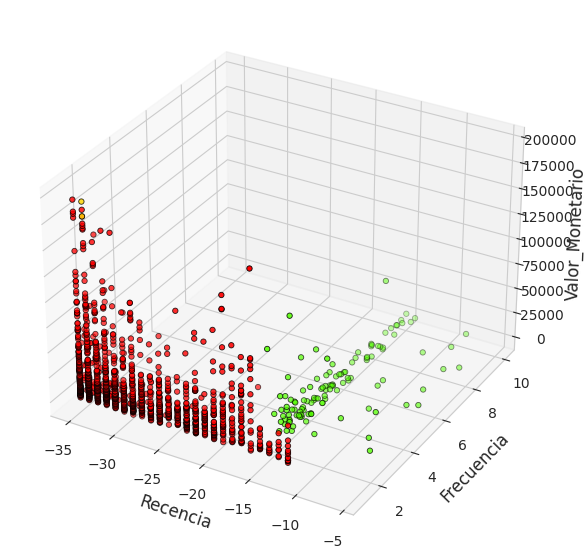

In [ ]:
plot_3d(cluster_stats(specc_3, df, data_variables)[1])

¡Podemos ver que *Cluster0* por sí solo contiene 3424, que es 83,25 de toda la población y representa 95,14 del monto total de ventas! Claramente, este resultado no significa pleno. ¡Probemos la agrupación espectral con 4 grupos!

* **Agrupación espectral con 4 grupos:**

In [ ]:
#
specc_4 = SpectralClustering(n_clusters= 4).fit(data_variables_scaled)

In [ ]:
#
cluster_stats(specc_4, df, data_variables)[0]

Recencia           Frecuencia            Valor_Monetario            \
             min  mean max        min mean   max             min      mean   
Cluster                                                                      
0            -35 -28.8 -12        1.0  1.0   3.0           622.8   27625.6   
1            -34 -34.0 -34        1.0  1.0   1.0        181589.0  188567.7   
2            -15 -13.3  -6        6.5  8.2  10.0           671.9    8682.7   
3            -15 -13.7  -6        1.4  3.7   6.4          1890.6   18289.4   

                  Primera_compra           Unicos_items              
              max            min  mean max          min  mean   max  
Cluster                                                              
0        194958.1            -35 -21.4 -12          1.0   3.8  12.0  
1        195546.3            -34 -34.0 -34         10.0  10.0  10.0  
2         70022.0             -1  -0.2   0          1.0   1.2   1.9  
3        121795.3             -2  -0.1   0          1.0   1.3   2.0

In [ ]:
#
#clusters_summary(cluster_stats(specc_4, df, data_variables)[1], df)

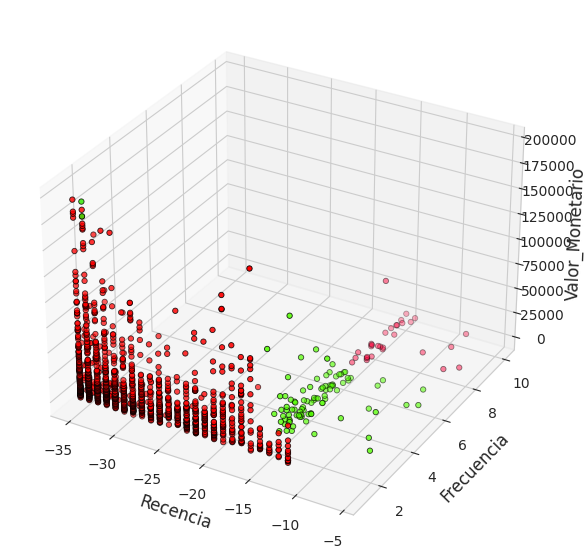

In [ ]:
plot_3d(cluster_stats(specc_4, df, data_variables)[1])

¡Podemos ver que *Cluster1* por sí solo contiene 4034, que es el 98,1 de toda la población y representa el 97,37 del monto total de ventas! Además, este resultado no significa completo.
¡Probemos KMeans con 5 clusters!

<a id='part5'></a>
## <font color=#ba4a00><strong>K-Means:

* K-Means con 5 clusters:

In [ ]:
#
kmeans = KMeans(n_clusters= 5, max_iter= 1000, random_state= 42).fit(data_variables_scaled)

In [ ]:
#
cluster_stats(kmeans, df, data_variables)[0]

Recencia           Frecuencia            Valor_Monetario            \
             min  mean max        min mean   max             min      mean   
Cluster                                                                      
0            -32 -19.4 -12        1.0  1.0   3.0          2191.5   24404.9   
1            -35 -31.0 -20        1.0  1.1   2.0           622.8   16366.3   
2            -35 -31.5 -16        1.0  1.1   2.0         65117.0  107763.9   
3            -35 -30.8 -25        1.0  1.0   2.0          1817.5   29844.3   
4            -15 -13.6  -6        1.4  4.8  10.0           671.9   15867.6   

                  Primera_compra           Unicos_items             
              max            min  mean max          min mean   max  
Cluster                                                             
0         93260.1            -24 -18.0 -12          2.0  5.4  11.0  
1         73618.6            -33 -19.3 -12          1.0  2.6   5.0  
2        195546.3            -35 -25.5 -12          1.5  4.7  11.0  
3         75245.4            -35 -29.4 -17          2.0  5.4  12.0  
4        121795.3             -2  -0.2   0          1.0  1.3   2.0

In [ ]:
#
#kmeans_cs = clusters_summary(cluster_stats(kmeans, df, data_variables)[1], df)
#kmeans_cs

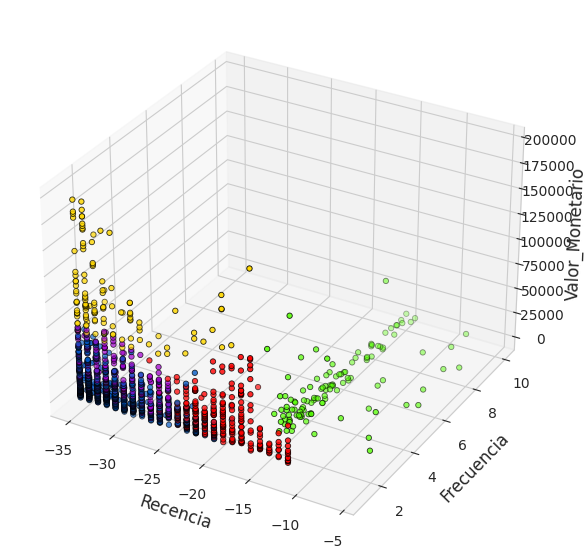

In [ ]:
plot_3d(cluster_stats(kmeans, df, data_variables)[1])

Al examinar los dataframe resumidos y la figura anteriores, podemos notar que KMeans en realidad da como resultado una mejor separación de grupos en comparación con la agrupación espectral. Sin embargo, los resultados no parecen muy informativos y creemos que podemos obtener una mejor solución mediante una mayor optimización del modelo. Por lo tanto, volveremos a verificar la mejor cantidad de clústeres para KMeans.

In [ ]:
#
Scores ={'Davies_Bouldin_Score': [],
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': []}

for k in range(4,9):
    kmeans = KMeans(n_clusters= k).fit(data_variables_scaled)
    Scores['Davies_Bouldin_Score'].append(davies_bouldin_score(data_variables_scaled,
                                                               kmeans.labels_))
    Scores['Calinski_Harabasz_Score'].append(calinski_harabasz_score(data_variables_scaled,
                                                                     kmeans.labels_))
    Scores['Silhouette_Score'].append(silhouette_score(data_variables_scaled,
                                                       kmeans.labels_))

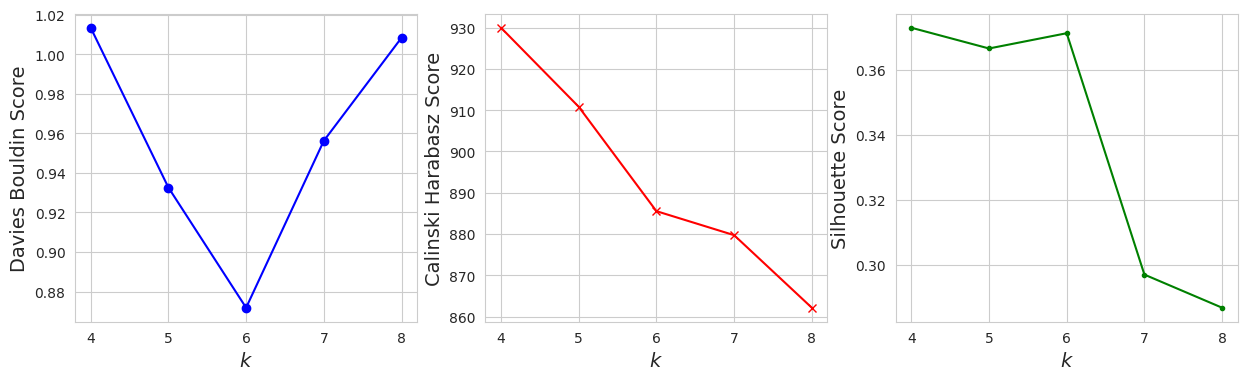

In [ ]:
#
plot_scores(4,9,Scores['Davies_Bouldin_Score'], Scores['Calinski_Harabasz_Score'],
            Scores['Silhouette_Score'])

Los gráficos de diferentes métricas de evaluación utilizadas en diferentes valores de K indican que K=6 puede producir una buena solución. Entonces, examinaremos esta solución.

* **KMeans con 6 clusters:**

In [ ]:
#
kmeans = KMeans(n_clusters= 6, max_iter= 1000, random_state= 42).fit(data_variables_scaled)

In [ ]:
#
kmeans_results = cluster_stats(kmeans, df, data_variables)[1]
cluster_stats(kmeans, df, data_variables)[0]

Recencia           Frecuencia            Valor_Monetario            \
             min  mean max        min mean   max             min      mean   
Cluster                                                                      
0            -35 -31.3 -20        1.0  1.1   2.0           622.8   16618.9   
1            -32 -19.5 -12        1.0  1.0   3.0          1274.6   23626.4   
2            -15 -13.1  -6        5.7  7.7  10.0           671.9    7867.3   
3            -35 -31.4 -16        1.0  1.0   2.0         66450.0  109864.5   
4            -15 -13.8  -6        1.4  3.5   5.5          1890.6   19477.4   
5            -35 -30.7 -24        1.0  1.0   2.0          1817.5   32176.7   

                  Primera_compra           Unicos_items             
              max            min  mean max          min mean   max  
Cluster                                                             
0         73618.6            -35 -19.6 -12          1.0  2.6   5.0  
1         93260.1            -25 -17.9 -12          2.0  5.2  11.0  
2         70022.0             -1  -0.2   0          1.0  1.2   1.9  
3        195546.3            -35 -25.1 -12          1.5  4.4  10.0  
4        121795.3             -2  -0.1   0          1.0  1.3   2.0  
5         93481.0            -35 -29.5 -17          2.5  5.7  12.0

In [ ]:
#
#kmeans_cs = clusters_summary(cluster_stats(kmeans, df, data_variables)[1], df)
#kmeans_cs

AttributeError: 'DataFrame' object has no attribute 'Cluster'

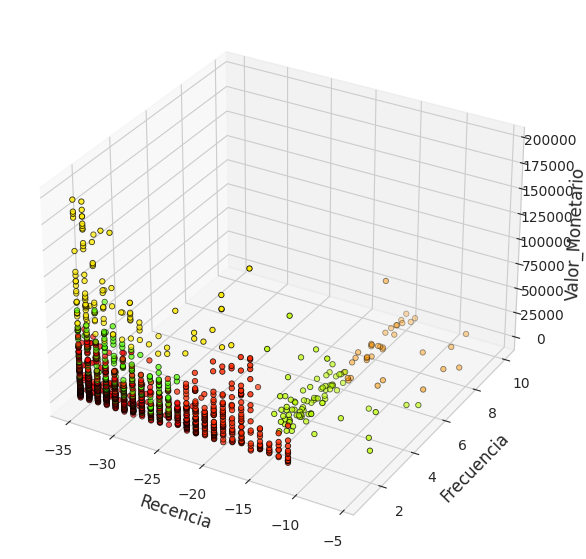

In [ ]:
#
plot_3d(cluster_stats(kmeans, df, data_variables)[1])

Al examinar el dataframe cluster_summary, el marco de datos cluster_stats y el diagrama de dispersión anterior, es interesante ver que cada grupo contiene un grupo de consumidores que tienen ciertas características distintas e intrínsecas, como se detalla a continuación.

<a id='part6'></a>
## <font color=#ba4a00><strong>Cluster Analysis:

NameError: name 'kmeans_cs' is not defined

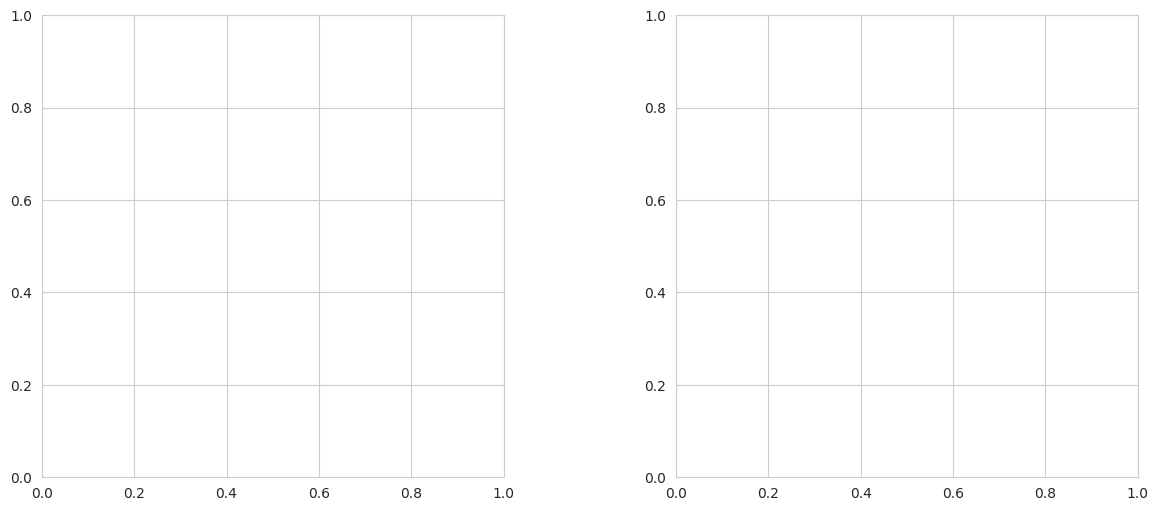

In [ ]:
# Dos gráficos circulares para comparar conglomerados en términos de proporción de población representada y ventas totales
# cantidad proporción
def func(pct):
    return "{:.1f}%".format(pct)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 6), subplot_kw=dict(aspect="equal"))

wedges, text1, autotexts = ax[1].pie(kmeans_cs['%sales_total'].values,
                                  autopct=lambda pct: func(pct),
                                  textprops=dict(color="w", fontsize= 12))
wedges, text2, autotexts = ax[0].pie(kmeans_cs['%clientes'].values,
                                  autopct=lambda pct: func(pct),
                                  textprops=dict(color="w", fontsize= 12))
ax[0].legend(kmeans_cs.index,
          title="Segmentos de Clientes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize= 12)

ax[1].set_title("Proporción del monto total de Ventas", fontsize= 18)
ax[0].set_title("Proporción de Población", fontsize= 18)

*Cluster5* contiene 314 clientes, compuestos por el 7% de toda la población. Este grupo parece ser el *grupo más rentable* ya que representa el 19% del importe total de las ventas. La mayoría de los clientes de este grupo comenzaron a comprar en el minorista en línea en el segundo trimestre del año con una primera compra promedio de 7,2, y continuaron hasta el final del año con una antigüedad promedio de 2,7 meses desde la última compra. Además, los clientes de este grupo parecen comprar con frecuencia durante el mes con una frecuencia promedio de 1,2 transacciones por mes. Por lo tanto, este grupo también puede clasificarse como de alta actualidad y alta frecuencia.

Por el contrario, *Cluster1* incluye 834 clientes, lo que representa el 19,8% de toda la población y representa sólo el 5,3% del importe total de las ventas. Este grupo parece ser el menos rentable ya que ninguno de sus clientes compró nada en los últimos cinco meses del año. Incluso durante los primeros siete meses del año, los consumidores no compraron con frecuencia y el valor promedio de la frecuencia fue de sólo 1 transacción por mes.

*Cluster3* contiene 1096 clientes, compuestos por el 26% de la población total y representa el 8% del monto total de ventas. Este grupo incluye nuevos clientes con una primera compra promedio de 3 y una antigüedad promedio de 1,8.

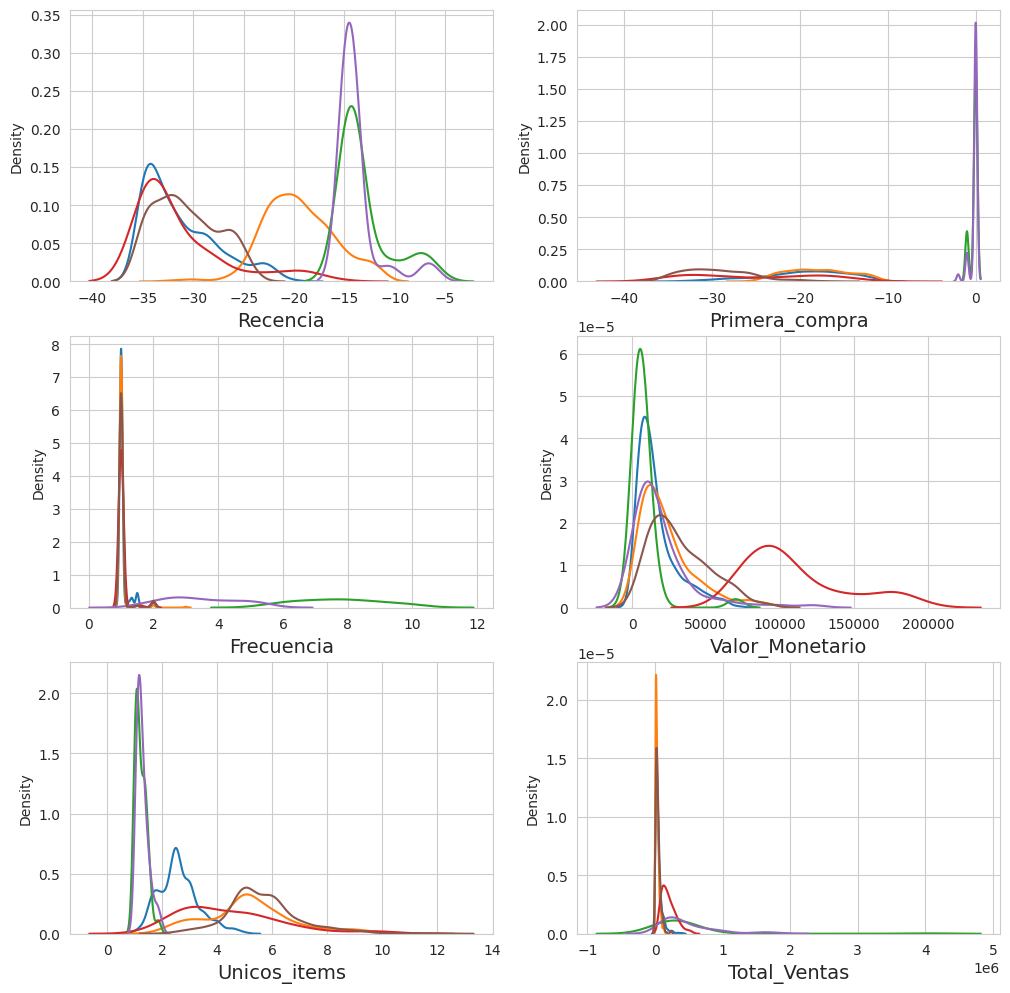

In [ ]:
#
plot_dist(kmeans_results, ['Recencia', 'Primera_compra', 'Frecuencia', 'Valor_Monetario',
                           'Unicos_items', 'Total_Ventas'])

*Cluster2* contiene 232 clientes, lo que representa el 5% de la población total y representa el 5% de las ventas totales. Este segmento tiene una rentabilidad bastante alta con un valor monetario promedio de £438 por transacción y una frecuencia moderada con un promedio de 1,1 transacciones por mes. Lo interesante de este grupo es el gran número promedio de artículos únicos en cada transacción. Esto indica que la mayoría de los clientes de este segmento son en realidad clientes organizacionales, no individuos.

Además, los clientes de *Cluster0* son más recientes que los de CLuster2. Este segmento es el más grande, incluye el 32% de toda la población y representa el 41% de las ventas totales. Este segmento incluye a los clientes leales que comenzaron a comprar en el minorista en línea en el primer trimestre del año con un promedio de primera compra de 10,4 y mantuvieron una frecuencia de compra moderada y alta reciente con un promedio de 1,6.

Finalmente, *CLuster4* contiene aproximadamente el 9% de toda la población y representa el 21% del monto total de ventas. Los clientes de este segmento compran con frecuencia con una frecuencia promedio de 2,2 transacciones por mes. También tienen un valor monetario moderado, £308,7 por transacción. Este segmento puede considerarse como el segundo segmento más rentable.

Ahora podemos utilizar los grupos resultantes para responder las siguientes preguntas:
* ¿Quiénes son los clientes más o menos valiosos para el negocio? ¿Cuáles son las características distintivas de ellos?
* ¿Quiénes son los clientes más/menos leales y cómo se caracterizan?
* ¿Cuáles son los patrones de comportamiento de compra de los clientes? ¿Qué productos/artículos han comprado los clientes juntos con frecuencia? ¿En qué secuencia se han comprado los productos?
* ¿Cuáles son los patrones de ventas en términos de diversas perspectivas, como productos/artículos, regiones y tiempo (semanal, mensual, trimestral, anual y estacional), etc.?

**References:**

- Chen, D., Sain, S. & Guo, K. J: "Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining" (2012) 19: 197. https://doi.org/10.1057/dbm.2012.17*

- *Kumar V., & Werner Reinartz: Customer Relationship Management_Concept, Strategy, and Tools. 10.1007/978-3-662-55381-7*